In [1]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from textwrap import wrap
import time
from sklearn.svm import LinearSVC
from sklearn import svm
from glob import glob
import PIL
import re


# for data preparation and others
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# models tried
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [2]:
#Data Preprocessing

df = pd.read_csv("df_new.csv", delimiter=",", header = None)
X = df.iloc[1:]
X = np.asarray(X.values)
X = np.delete(X, 0, 1)
X = np.transpose(X)

y = df.iloc[0]
y = y[1:]
y = np.asarray(y)
y = np.transpose(y)

features_names = df.iloc[1:]
features_names = features_names.iloc[:,0]
features_names = np.asarray(features_names)
target_names = df.iloc[0]
target_names = target_names[1:]
target_names = np.asarray(target_names)
target_names = np.transpose(target_names)


indx = []
for i in range(len(features_names)):
  indx.append(i)
print(len(features_names))

234002


In [3]:
#splitting the data into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


In [4]:
#normalizing or scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [5]:
#filter technique (Mutual Information [MI])
startTime = time.time()
mi = mutual_info_classif(X_train, y_train, discrete_features='auto', n_neighbors=3, copy=True, random_state=42)
endTime = time.time()
print('Time: ' + str(endTime - startTime))


Time: 791.9930362701416


In [6]:
#oraganizing MI data
gains = np.asarray(mi)
indexes = np.where(gains != 0)[0]
print(len(indexes))


128725


In [7]:
#traingin a linearSVC model with different numbers of MI features starting from the top 2 to the top 1000
#the highest accuracy corresponds to the best number of features
graph_MI = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
TotalTime = time.time()
for i in range (2,1000):
  
  it = sorted(range(len(gains)), key = lambda sub: gains[sub])[-i:]
  x_train = X_train[:, it]
  x_test = X_test[:, it]
  Y_train = y_train[:]
  Y_test = y_test[:]
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  clf = LinearSVC(random_state=42)
  clf.fit(x_train, Y_train)
  scores = clf.score(x_test, Y_test)
  endTime = time.time()
  y_pred = clf.predict(x_test)
  graph_MI.append(scores)
EndTime = time.time()
print('TotalTime: ' + str(EndTime - TotalTime))

TotalTime: 172.8383767604828


Text(0, 0.5, 'Accuracy')

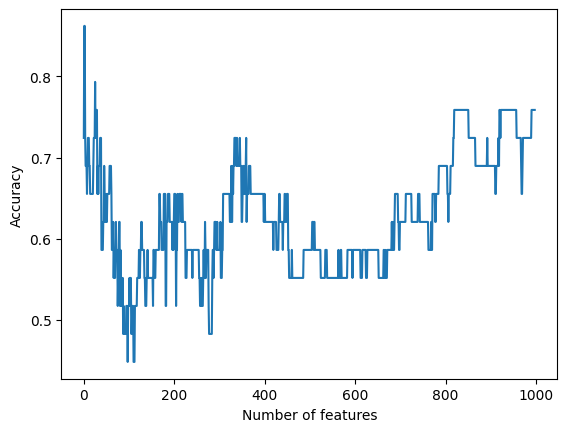

In [8]:
#Plot a graph with all accuracy scores
plt.plot(graph_MI)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')


In [9]:
#Display the best number of features
graph_MI = np.asarray(graph_MI)
print(np.argmax(graph_MI))
print(graph_MI[np.argmax(graph_MI)]) 
print(np.where(graph_MI == graph_MI[np.argmax(graph_MI)]))

#Since the counting started from 2 in the for loop, 2 should be added to those numbers
#In other words, the least number of features that can generate top accuracy is 4 not 2

1
0.8620689655172413
(array([1, 2]),)


In [10]:
graph_MI[1]
#the higest accuracy is with 4 features because the list starts from 2

np.float64(0.8620689655172413)

In [11]:
#Confusion matrix (4 features of MI) *******

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



it = sorted(range(len(gains)), key = lambda sub: gains[sub])[-4:]
startTime = time.time()
x_train = X_train[:, it]
x_test = X_test[:, it]
Y_train = y_train[:]
Y_test = y_test[:]
x_train = x_train.astype('float32')
X_test = x_test.astype('float32')

clf = LinearSVC(random_state=42)
clf.fit(x_train, Y_train)
scores = clf.score(x_test, Y_test)
endTime = time.time()
print('Score: ' + str(scores))
print('Time: ' + str(endTime - startTime))
y_pred = clf.predict(x_test)


print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))



Score: 0.8620689655172413
Time: 0.003935575485229492
[[ 2  0  0]
 [ 0 12  2]
 [ 0  2 11]]
                 precision    recall  f1-score   support

 EarlyFlowering       1.00      1.00      1.00         2
  LateFlowering       0.86      0.86      0.86        14
MediumFlowering       0.85      0.85      0.85        13

       accuracy                           0.86        29
      macro avg       0.90      0.90      0.90        29
   weighted avg       0.86      0.86      0.86        29

0.8620689655172413
(np.float64(0.8620689655172413), np.float64(0.8620689655172413), np.float64(0.8620689655172413), None)


In [12]:
#Wrapper Technique (Random Forest [RF])
#making a for loop to find the best number of estimators (trees) based on accuracy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
scores = []
start_time = time.time()
for i in range (1, 1000):
  regressor = RandomForestClassifier(n_estimators=i, random_state=42)
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)
  sorted_features = sorted (zip(map(lambda x: round(x, 4), regressor.feature_importances_), indx),reverse=True)
  important_f = []
  

  for s in sorted_features:
    if s[0] != 0:
      important_f.append(s[1])
  important_f = np.transpose(important_f)
  important_f = np.asarray(important_f)
    
    
  #checking the similarities in the first 93 features in MI with features used in RF (n_estimators = i)
  it = sorted(range(len(gains)), key = lambda sub: gains[sub])[-4:]
  similarity = []
  count = 0
  for f in important_f:
    for t in it:
      if (f == t):
        count = count + 1
        similarity.append(f)
  scores.append(accuracy_score(y_test, y_pred))
endTime = time.time()
print("Total Time: ", str(endTime - start_time))

Total Time:  7387.433214902878


Text(0, 0.5, 'Accuracy')

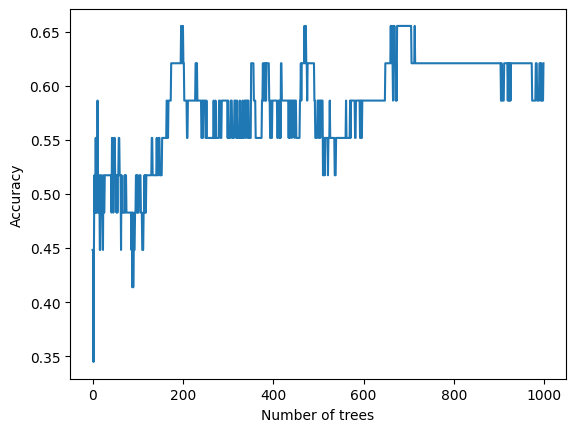

In [13]:
#Plot a graph with all accuracy scores
plt.plot(scores)
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')


In [14]:
#Display the best number of trees
scores = np.asarray(scores)
print(np.argmax(scores))
print(scores[np.argmax(scores)]) 
print(np.where(scores == scores[np.argmax(scores)]))

#Since the counting started from 1 not zero in the for loop, 1 should be added to those numbers
#In other words, the least number of features that can generate top accuracy is 197 not 196

196
0.6551724137931034
(array([196, 198, 200, 469, 472, 660, 662, 663, 666, 668, 674, 675, 676,
       677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689,
       690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702,
       703, 704, 705, 713]),)


In [15]:
#to get the common features between top 4 MI features and the features of the 197 trees in the Random forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
ST = time.time()
regressor = RandomForestClassifier(n_estimators=197, random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
sorted_features = sorted (zip(map(lambda x: round(x, 4), regressor.feature_importances_), indx),reverse=True)
important_f = []
  

for s in sorted_features:
  if s[0] != 0:
    important_f.append(s[1])
important_f = np.transpose(important_f)
important_f = np.asarray(important_f)

#checking the similarities in the first 4 features in MI with features used in RF (n_estimators = 197)
it = sorted(range(len(gains)), key = lambda sub: gains[sub])[-4:]
similarity = []
count = 0
for f in important_f:
  for t in it:
    if (f == t):
      count = count + 1
      similarity.append(f)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))
print("the number of important features used: ", len(important_f))
print ("number of similar features: ", len(similarity))  

ET = time.time()
print("time: ", ET - ST)
print("\n")


0.6551724137931034
[[ 1  0  1]
 [ 0 10  4]
 [ 0  5  8]]
                 precision    recall  f1-score   support

 EarlyFlowering       1.00      0.50      0.67         2
  LateFlowering       0.67      0.71      0.69        14
MediumFlowering       0.62      0.62      0.62        13

       accuracy                           0.66        29
      macro avg       0.76      0.61      0.66        29
   weighted avg       0.67      0.66      0.65        29

(np.float64(0.6666666666666666), np.float64(0.6551724137931034), np.float64(0.6547760602457393), None)
the number of important features used:  2840
number of similar features:  4
time:  3.96167254447937




In [16]:
#The wrapper technique (Recursive Feature Elimination [RFE])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
graph_RFE = []
Total_time = time.time()
for i in range(1, 1000):
  startTime = time.time()
  estimator = LinearSVC(random_state=42)
  selector = RFE(estimator, n_features_to_select= i, step=0.5)
  selector = selector.fit(X_train, y_train)
  # testing the model
  y_pred = selector.predict(X_test)
  graph_RFE.append(selector.score(X_test, y_test))
EndTime = time.time()
print('TotalTime: ' + str(EndTime - Total_time))


(116, 234002)
(116,)
(29, 234002)
(29,)
TotalTime: 11569.809084415436


Text(0, 0.5, 'Accuracy')

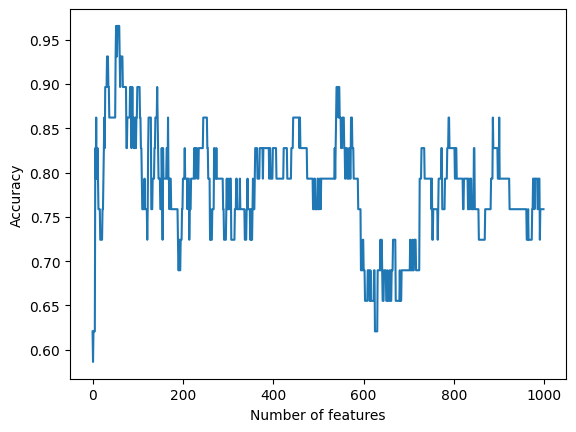

In [17]:
#Plot a graph with all accuracy scores
plt.plot(graph_RFE)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')


In [18]:
#Display the best number of features
graph_RFE = np.asarray(graph_RFE)
print(np.argmax(graph_RFE))
print(graph_RFE[np.argmax(graph_RFE)])
print(np.count_nonzero(np.where(graph_RFE == graph_RFE[np.argmax(graph_RFE)])))
print(np.where(graph_RFE == graph_RFE[np.argmax(graph_RFE)]))

#Since the counting started from 1 not zero in the for loop, 1 should be added to those numbers
#In other words, the least number of features that can generate top accuracy is 53 not 52

52
0.9655172413793104
6
(array([52, 55, 56, 57, 58, 59]),)


In [19]:
#The wrapper method (recursive feature elimination RFE) 53 features only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

startTime = time.time()
estimator = LinearSVC(random_state=42)
selector = RFE(estimator, n_features_to_select= 53, step=0.5)
selector = selector.fit(X_train, y_train)
endTime = time.time()
print('Time: ' + str(endTime - startTime))
# testing the model
y_pred = selector.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(selector.score(X_test, y_test))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))

print(np.count_nonzero(selector.support_ == 1))


(116, 234002)
(116,)
(29, 234002)
(29,)
Time: 11.23204779624939
0.9655172413793104
0.9655172413793104
[[ 2  0  0]
 [ 0 13  1]
 [ 0  0 13]]
                 precision    recall  f1-score   support

 EarlyFlowering       1.00      1.00      1.00         2
  LateFlowering       1.00      0.93      0.96        14
MediumFlowering       0.93      1.00      0.96        13

       accuracy                           0.97        29
      macro avg       0.98      0.98      0.98        29
   weighted avg       0.97      0.97      0.97        29

(np.float64(0.9679802955665024), np.float64(0.9655172413793104), np.float64(0.9655172413793104), None)
53


In [20]:
#Create a list with indices of RFE Features
RFE_features = np.where(selector.support_ == 1)
RFE_features = np.asarray(RFE_features)
rfe_f = []
for i in RFE_features:
  for s in i:
    rfe_f.append(s)
rfe_f = np.asarray(rfe_f)

In [21]:
#Create list with common features among techniques
similar_all = []
similar_rfe_RF = []
similar_rfe_MI = []

count = 0
for f in it:
  for t in rfe_f:
    if (f == t):
      count = count + 1
      similar_rfe_MI.append(f)
print("number of similar features between RFE and MI: ", count)

count = 0
for f in important_f:
  for t in rfe_f:
    if (f == t):
      count = count + 1
      similar_rfe_RF.append(f)
print("number of similar features between RFE and RF: ", count)

count = 0
for f in similarity:
  for t in rfe_f:
    if (f == t):
      count = count + 1
      similar_all.append(f)
print("number of similar features between RF and MI: ", len(similarity))
print("number of similar features between RFE, RF and MI: ", count)


number of similar features between RFE and MI:  4
number of similar features between RFE and RF:  28
number of similar features between RF and MI:  4
number of similar features between RFE, RF and MI:  4


In [22]:
#A LinearSVC Model using the similar features between all of them
startTime = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train = X_train[:, similar_all]
X_test = X_test[:, similar_all]
Y_train = y_train[:]
Y_test = y_test[:]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train[:]
Y_test = Y_test[:]
clf = LinearSVC(random_state=42)

clf.fit(X_train, Y_train)

endTime = time.time()
print('Score: ' + str(clf.score(X_test, Y_test)))
print('Time: ' + str(endTime - startTime))
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))


Score: 0.8620689655172413
Time: 4.4479382038116455
[[ 2  0  0]
 [ 0 12  2]
 [ 0  2 11]]
                 precision    recall  f1-score   support

 EarlyFlowering       1.00      1.00      1.00         2
  LateFlowering       0.86      0.86      0.86        14
MediumFlowering       0.85      0.85      0.85        13

       accuracy                           0.86        29
      macro avg       0.90      0.90      0.90        29
   weighted avg       0.86      0.86      0.86        29

0.8620689655172413
(np.float64(0.8620689655172413), np.float64(0.8620689655172413), np.float64(0.8620689655172413), None)


In [23]:
#Create a list with common features between at least two techniques
common = []
zzz = []
zzz = similar_all + similar_rfe_MI + similar_rfe_RF + similarity
for i in zzz:
  if i in common:
    pass
  else:
    common.append(i)
print ("Number of common features between at least two techniques: ",len(common))

Number of common features between at least two techniques:  28


In [24]:
#A LinearSVC Model using the common features between at least two techniques
startTime = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = X_train[:, common]
X_test = X_test[:, common]
Y_train = y_train[:]
Y_test = y_test[:]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train[:]
Y_test = Y_test[:]
clf = LinearSVC(random_state=42)

clf.fit(X_train, Y_train)

endTime = time.time()
print('Score: ' + str(clf.score(X_test, Y_test)))
print('Time: ' + str(endTime - startTime))
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))


Score: 0.8620689655172413
Time: 4.438744783401489
[[ 2  0  0]
 [ 0 12  2]
 [ 0  2 11]]
                 precision    recall  f1-score   support

 EarlyFlowering       1.00      1.00      1.00         2
  LateFlowering       0.86      0.86      0.86        14
MediumFlowering       0.85      0.85      0.85        13

       accuracy                           0.86        29
      macro avg       0.90      0.90      0.90        29
   weighted avg       0.86      0.86      0.86        29

0.8620689655172413
(np.float64(0.8620689655172413), np.float64(0.8620689655172413), np.float64(0.8620689655172413), None)


In [25]:
#Save in a Data Frame
similar_all_names = []
for i in similar_all:
  similar_all_names.append(features_names[i])
df_similar_All = pd.DataFrame(similar_all_names)
df_similar_All.to_csv(r'Similar_All_Features.csv', index=False) 

In [26]:
similar_rfe_MI_names = []
for i in similar_rfe_MI:
  similar_rfe_MI_names.append(features_names[i])
df_similar_rfe_MI = pd.DataFrame(similar_rfe_MI_names)
df_similar_rfe_MI.to_csv(r'Similar_RFE_MI_Features.csv', index=False) 

In [27]:
similar_rfe_RF_names = []
for i in similar_rfe_RF:
  similar_rfe_RF_names.append(features_names[i])
df_similar_rfe_RF = pd.DataFrame(similar_rfe_RF_names)
df_similar_rfe_RF.to_csv(r'Similar_RFE_RF_Features.csv', index=False) 

In [28]:
similar_MI_RF = []
for i in similarity:
  similar_MI_RF.append(features_names[i])
df_similar_MI_RF = pd.DataFrame(similar_MI_RF)
df_similar_MI_RF.to_csv(r'Similar_MI_RF_Features.csv', index=False) 

In [29]:
rfe_f_names = []
for i in rfe_f:
  rfe_f_names.append(features_names[i])
df_RFE = pd.DataFrame(rfe_f_names)
df_RFE.to_csv(r'RFE_features.csv', index=False) 

In [30]:
MI_f_names = []
for i in it:
  MI_f_names.append(features_names[i])
df_MI = pd.DataFrame(MI_f_names)
df_MI.to_csv(r'MI_features.csv', index=False) 

In [31]:
RF_f_names = []
for i in important_f:
  RF_f_names.append(features_names[i])
df_RF = pd.DataFrame(RF_f_names)
df_RF.to_csv(r'RF_features.csv', index=False) 

In [32]:
common_all = []
for i in common:
  common_all.append(features_names[i])
df_common = pd.DataFrame(common_all)
df_common.to_csv(r'common_all.csv', index=False) 